# EMERGE: Empirical predictions of galaxy merger rates since z∼6
##### About:
This notebook is intended to provide the scripts necessary to reproduce the key results shown [here](https://ui.adsabs.harvard.edu/abs/2020arXiv200102687O/abstract). I omit plots that include data and results of other works.

##### Data:
The data necessary to reproduce these results can be found [here](http://www.usm.uni-muenchen.de/emerge/data/catalog/hdf5/). This data is produced using the code [EMERGE](http://www.usm.uni-muenchen.de/emerge/)

##### Code:
To run this notebook you will also need to install my personal library of analysis tools [galaxybox](https://github.com/jaoleary/galaxybox). If there are questions regarding the usage of these tools please consult that repository directly...or contact me.

##### Discalimer:
This notebook relies on publicly available data and codes, I cannot gurantee that updates to either of this won't result in a change to the results shown in this notebook or the associated paper. If for some reason you are unable to run this notebook or if you find some error **please** contact me.

# RUN THESE CELLS FIRST

### IMPORT LIBRARIES

In [1]:
from galaxybox import sim_managers as gb

# plotting
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
import matplotlib.patheffects as PathEffects
import matplotlib.patches as patches
from matplotlib import container
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

#astropy
from astropy import cosmology as apcos
import astropy.units as apunits

# scipy
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic
import scipy.interpolate as interpolate
import scipy.integrate as integrate

# other
import os
import pandas as pd
import numpy as np
from multiprocessing import Pool
from jupyterthemes import jtplot # This is not a necessary library. But im a sucker for dark themes
from tqdm.auto import tqdm
import h5py
import warnings
warnings.filterwarnings("ignore")

### PLOTTING DEFAULTS

In [2]:
jtplot.reset()
plt.rcParams.update({'axes.linewidth' : 2,
                     'xtick.labelsize' : 16,
                     'xtick.major.width' : 2,
                     'xtick.major.size'  : 6,
                     'xtick.minor.width'  : 1,
                     'xtick.minor.size'  : 3,
                     'xtick.top' : True,
                     'xtick.direction' : 'in',
                     'ytick.labelsize' : 16,
                     'ytick.major.width' : 2,
                     'ytick.major.size'  : 6,
                     'ytick.minor.width'  : 1,
                     'ytick.minor.size'  : 3,
                     'ytick.right' : True,
                     'ytick.direction' : 'in',
                     'font.family':'serif',
                     'mathtext.fontset': 'cm'})

### IMPORT DATA

In [3]:
# First we need to import galaxy/halo merger trees. This is a bulk import and is pretty memory heavy. You can do this piecemeal if necessary....or work with a smaller/less resolved simulation. 
P200 = gb.Universe(param_path = '../../Programs/emerge-dev/parameterfiles/P200.param', sim_type = 'emerge', include=['trees'])
# This next line on only needs to be run once, the merger lists are subseqently saved and can be reimported by adding `mergers` to the include argument of `Universe`.
P200.add_galaxy_mergers(source='trees', save=True, enforce_mass_threshold=False, desc_mass_correction=True, dropna=False) # desc_mass correction is expensive for little gain. setting it false should speed up this step considerably

# these two are only needed if you want to compute the halo merger rates in section 2. 
#P200.add_halo_trees()
#P200.add_halo_mergers(source='trees',save=True) 

# Using a sorted index makes searching trees much faster
P200.galaxy.sort_index()


Making merger list from trees


# Section 2: DARK MATTER SIMULATIONS AND EMERGE

In [5]:
bins = 30
HMF = np.zeros((len(P200.halo.scales),bins))
for j, s in enumerate(tqdm(P200.halo.scales[::-1])):
    temp = P200.halo.list(scale_factor=s)
    if j == 0:
        hist_scale, edges = np.histogram(temp.mvir,bins=bins)
    else:
        hist_scale, edges = np.histogram(temp.mvir,bins=edges)
    HMF[j,:] += hist_scale
    del temp
    
bins=edges
def count_halos(mass,scale_factor):    
    centers = (bins[:-1] + bins[1:]) / 2
    db = (bins[1]-bins[0])
    hmf_func = interpolate.interp2d(centers,P200.halo.scales[::-1],HMF)
    if isinstance(scale_factor,float) or isinstance(scale_factor,int):
        hmf_1d = interpolate.CubicSpline(centers,hmf_func(centers,scale_factor)/db)
        return int(np.round(integrate.quad(hmf_1d,mass[0],mass[1])[0]))
    else:
        N_halos = np.zeros(len(scale_factor))
        for i, s in enumerate(scale_factor):
            hmf_1d = interpolate.CubicSpline(centers,hmf_func(centers,s)/db)
            N_halos[i] = int(np.round(integrate.quad(hmf_1d,mass[0],mass[1])[0]))
        return N_halos

In [ ]:
def col(n, tot):
    return plt.cm.jet(n / float(tot), 1)

shrink=0.6
L = 9

fig, ax = plt.subplots(2,1, figsize=(L*np.sqrt(2)/2, L*np.sqrt(2)*shrink))

ax[0].tick_params(axis='both', direction='in', which = 'both', bottom=True, top=True, left=True, right=True)

ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlim([1,5])
ax[0].set_ylim([1e-2,5])
ax[0].set_xlabel('Redshift',size=14)

ax[0].set_ylabel('$dN/dt \, \\left[\mathrm{Gyr}^{-1}\\right]$',size=16)
for tick in ax[1].yaxis.get_major_ticks():
    tick.label.set_fontsize(12)
    
for tick in ax[0].yaxis.get_major_ticks():
    tick.label.set_fontsize(12)
    
for tick in ax[1].xaxis.get_major_ticks():
    tick.label.set_fontsize(12)
    
for tick in ax[0].xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    

MR = np.logspace(-4,0,30)
centers = (MR[:-1] + MR[1:])/2

scale, redshift, time = gb.make_time_bins(cosmology=P200.cosmology, db = 1, db_type='time')
z = (redshift[1:] + redshift[:-1])/2
a = (scale[1:] + scale[:-1])/2
dt = np.diff(time)

mass_bins = [(np.log10(5e10),np.log10(1.5e11)),
             (np.log10(1.5e11),np.log10(5e11)),
             (np.log10(5e11),np.log10(1.5e12)),
             (np.log10(1.5e12),np.log10(5e12)),
             (np.log10(5e12),np.log10(1.5e13)),
             (np.log10(1.5e13),np.log10(5e13)),
             (np.log10(5e13),np.log10(1.5e14)),
             (np.log10(1.5e14),np.log10(5e14))] 
hands = []
min_mass = np.log10((1.98e8)*10/P200.HubbleParam)
mr_bins = np.logspace(0,5,10)
for i,mass in enumerate(mass_bins):
    N_halos = count_halos(mass, a)
    N_mergers, edges = P200.halo.mergers.hist(axis='Scale', bins = scale, min_desc_mvir=mass[0],max_desc_mvir=mass[1], min_MR=1, max_MR = 4)

    clean = N_mergers > 0
    ax[0].plot(1+z[clean],N_mergers[clean]/N_halos[clean]/dt[clean], color=col(i,len(mass_bins)))
        
    if np.log10(np.mean(10**np.array(mass)))%1 == 0:
        lab = '$M_{0}=10^{' + '{:d}'.format(int(np.log10(np.mean(10**np.array(mass))))) +'}\, M_{\odot}$'
        hands.append(Line2D([0], [0], color=col(i,len(mass_bins)), lw=2, ls = '-',label=lab))
full_label = '$\\xi > 0.25$'
ax[0].annotate(full_label, xy=(1-0.02, 1-0.02), xycoords='axes fraction',
            size=16, ha='right', va='top')
ax[0].legend(handles=hands, frameon=False,prop={'size': 12})
ax[0].set_xticks(np.arange(1,7), minor=True)
ax[0].set_xticklabels(np.arange(1,6),minor=True, size=12)

labels = [item.get_text() for item in ax[0].get_xticklabels()]

labels[0] = 0
ax[0].set_xticks([1])
ax[0].set_xticklabels(labels)
#############################################################################################################################################
ax[1].tick_params(axis='both', direction='in', which = 'both', bottom=True, top=True, left=True, right=True)

ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlim([1e-5,1.5])
ax[1].set_ylim([0.1,1e8])
ax[1].set_xlabel('$\\xi = M_{i}/M_{1}$',size=14)

ax[1].set_ylabel('$dN/d\\xi/dz$',size=16)

MR = np.logspace(-4,0,30)
centers = (MR[:-1] + MR[1:])/2

scalefactor_bin, redshift_bin, cosmictime_bin = gb.target_redshift_bin(0.1,P200.cosmology,db=0.3)

mass_bins = [(np.log10(5e10),np.log10(1.5e11)),
             (np.log10(1.5e11),np.log10(5e11)),
             (np.log10(5e11),np.log10(1.5e12)),
             (np.log10(1.5e12),np.log10(5e12)),
             (np.log10(5e12),np.log10(1.5e13)),
             (np.log10(1.5e13),np.log10(5e13)),
             (np.log10(5e13),np.log10(1.5e14)),
             (np.log10(1.5e14),np.log10(5e14))] 
hands = []
min_mass = np.log10((1.98e8)*10/P200.HubbleParam)
for i,mass in enumerate(mass_bins):
    N_halos = count_halos(mass, np.mean(scalefactor_bin))
    N_mergers, edges = P200.halo.mergers.hist(axis=['MR'],min_scale=scalefactor_bin[0],max_scale=scalefactor_bin[1],min_desc_mvir=mass[0],max_desc_mvir=mass[1], max_MR = (10**mass[0])/(10**min_mass), inverse=True, log=True, bins='auto')
    if np.any(N_mergers==0):
        n_bins=30
        while np.any(N_mergers==0):
            N_mergers, edges = P200.halo.mergers.hist(axis=['MR'],min_scale=scalefactor_bin[0],max_scale=scalefactor_bin[1],min_desc_mvir=mass[0],max_desc_mvir=mass[1], max_MR = (10**mass[0])/(10**min_mass), inverse=True, log=True, bins=n_bins)
            n_bins -= 1
        
    peak = np.argmax(N_mergers)
    N_mergers = N_mergers[peak:]
    edges = edges[peak:]
    edges=10**edges
    du = np.abs(np.diff(edges))
    dz = np.abs(np.diff(redshift_bin))
    dv = (0.2**3)
    dm = (10**mass[1]) - (10**mass[0])
    centers = (edges[:-1] + edges[1:])/2
    ax[1].plot(centers,N_mergers/N_halos/du/dz,color=col(i,len(mass_bins)))
    if np.log10(np.mean(10**np.array(mass)))%1 == 0:
        lab = '$M_{0}=10^{' + '{:d}'.format(int(np.log10(np.mean(10**np.array(mass))))) +'}\, M_{\odot}$'
        hands.append(Line2D([0], [0], color=col(i,len(mass_bins)), lw=2, ls = '-',label=lab))

redshift_label = '{:.2f}'.format(np.mean(redshift_bin))
full_label = '$z=' + redshift_label + '$'
ax[1].annotate(full_label, xy=(0.02, 0.02), xycoords='axes fraction',
            size=14, ha='left', va='bottom')
ax[1].legend(handles=hands,frameon=False,prop={'size': 12})
ax[1].set_yticks(np.logspace(-1,8,10))

fig.tight_layout()
plt.show()


# Section 3: THE GALAXY-GALAXY MERGER RATE

## Section 3.1.1: Scaling with mass and redshift

Making bins evenly spaced in time


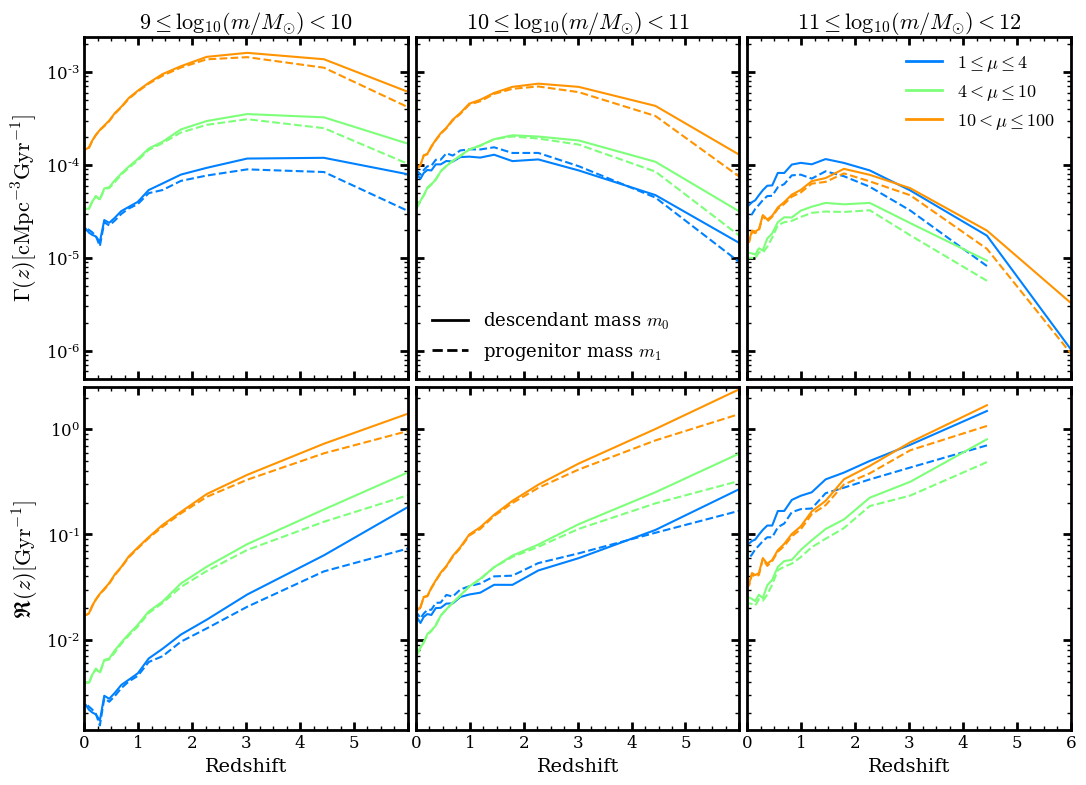

In [4]:
# Plot merger rates
L = 9
plt.rcParams['figure.figsize'] = (L*np.sqrt(2), L)
plt.rcParams["font.family"] = 'serif'
text = 12
plt.rcParams.update({
    'axes.labelsize': text,
    'xtick.labelsize': text,
    'ytick.labelsize': text,
    'axes.titlesize': text,
    'legend.handlelength': 2,
    'mathtext.fontset': 'cm'
})
fig, ax = plt.subplots(2, 3,sharey='row',sharex='col')
fig.subplots_adjust(hspace=0.025,wspace=0.025)

time = np.arange(2,14,2)
lbt = np.zeros(len(time)) 
minor_time  = np.arange(1, 13, 1)
lbt_m = np.zeros(len(minor_time)) 


for axi in ax.reshape(-1):
    axi.tick_params(axis='both', direction='in', which = 'both', bottom=True, top=True, left=True, right=True)
    axi.xaxis.set_minor_locator(ticker.FixedLocator(np.arange(0.25, 5.75+1, 0.25)))
    axi.xaxis.set_major_locator(ticker.FixedLocator(np.arange(0, 6+1, 1)))
    axi.set_yscale('log')


ax[0,0].set_title('$9 \leq \log_{10}(m/M_{\odot})<10$', size=16)
ax[0,1].set_title('$10 \leq \log_{10}(m/M_{\odot})<11$', size=16)
ax[0,2].set_title('$11 \leq \log_{10}(m/M_{\odot})<12$', size=16)

ax[0,0].set_ylabel('$\Gamma(z)[\mathrm{cMpc}^{-3}\mathrm{Gyr}^{-1}]$',size=16)

ax[1,0].set_ylabel('$\mathfrak{R}(z)[\mathrm{Gyr}^{-1}]$',size=16)

ax[1,0].set_xlabel('Redshift',size=14)
ax[1,1].set_xlabel('Redshift',size=14)
ax[1,2].set_xlabel('Redshift',size=14)

ax[0,0].set_xlim([0,6])
ax[0,1].set_xlim([0,6])
ax[0,2].set_xlim([0,6])
ax[0,0].set_xticklabels(np.arange(0,6))
ax[0,1].set_xticklabels(np.arange(0,6))
ax[0,2].set_xticklabels(np.arange(0,7))

scale, redshift, time = gb.make_time_bins(cosmology=P200.cosmology, db = 0.75, db_type='time')
z = (redshift[1:] + redshift[:-1])/2
dt = np.diff(time)
norm_vol = 1/(P200.BoxSize/P200.HubbleParam)**3
m_array = np.array([9,10,11,12])
mr_array = np.array([1,4,10,100])

for i in range(len(m_array)-1):
    min_mass = m_array[i]
    max_mass = m_array[i+1]
    norm_gal  = 1/P200.galaxy.count(target_scales=(scale[1:] + scale[:-1])/2, min_mass=min_mass, max_mass=max_mass)
    for j in range(len(mr_array)-1):

        min_MR = mr_array[j]
        max_MR = mr_array[j+1]
        
        N_merge, bin_edges = P200.galaxy.mergers.hist(axis='tdf', bins = time, min_desc_mstar=min_mass, max_desc_mstar=max_mass, min_MR=min_MR, max_MR=max_MR)
        clean = N_merge > 0
        ax[1,i].plot(z[clean],norm_gal[clean]*N_merge[clean]/dt[clean], color=plt.cm.jet((j+1)/float(4)))
        ax[0,i].plot(z[clean],norm_vol*N_merge[clean]/dt[clean], color=plt.cm.jet((j+1)/float(4)))
        
        N_merge, bin_edges = P200.galaxy.mergers.hist(axis='tdf', bins = time, min_main_mstar=min_mass, max_main_mstar=max_mass, min_MR=min_MR, max_MR=max_MR)
        clean = N_merge > 0
        ax[1,i].plot(z[clean],norm_gal[clean]*N_merge[clean]/dt[clean], color=plt.cm.jet((j+1)/float(4)),ls='--')
        ax[0,i].plot(z[clean],norm_vol*N_merge[clean]/dt[clean], color=plt.cm.jet((j+1)/float(4)),ls='--')

ax[0,0].set_ylim([5e-7,2e-3+(2e-3)*0.2])
ax[0,1].set_ylim([5e-7,2e-3+(2e-3)*0.2])
ax[0,2].set_ylim([5e-7,2e-3+(2e-3)*0.2])

ax[1,0].set_ylim([1.4e-3,2.5])
ax[1,1].set_ylim([1.4e-3,2.5])
ax[1,2].set_ylim([1.4e-3,2.5])
        
m0 = Line2D([0], [0], color='k', lw=2, ls = '-', label='descendant mass $m_{0}$')
m1 = Line2D([0], [0], color='k', lw=2, ls = '--', label='progenitor mass $m_{1}$')

mu1 = Line2D([0], [0], color=plt.cm.jet((0+1)/float(4)), lw=2, ls = '-', label='$1 \leq \mu \leq 4$')
mu2 = Line2D([0], [0], color=plt.cm.jet((1+1)/float(4)), lw=2, ls = '-', label='$4 < \mu \leq 10$')
mu3 = Line2D([0], [0], color=plt.cm.jet((2+1)/float(4)), lw=2, ls = '-', label='$10 < \mu \leq 100$')

ax[0,1].legend(handles=[m0,m1],frameon=False, prop={'size':13})
ax[0,2].legend(handles=[mu1,mu2,mu3],frameon=False, prop={'size':13})
plt.show()

## Section 3.1.2: Scaling with mass ratio

Making bin evenly spaced in time
Making bin evenly spaced in time
Making bin evenly spaced in time


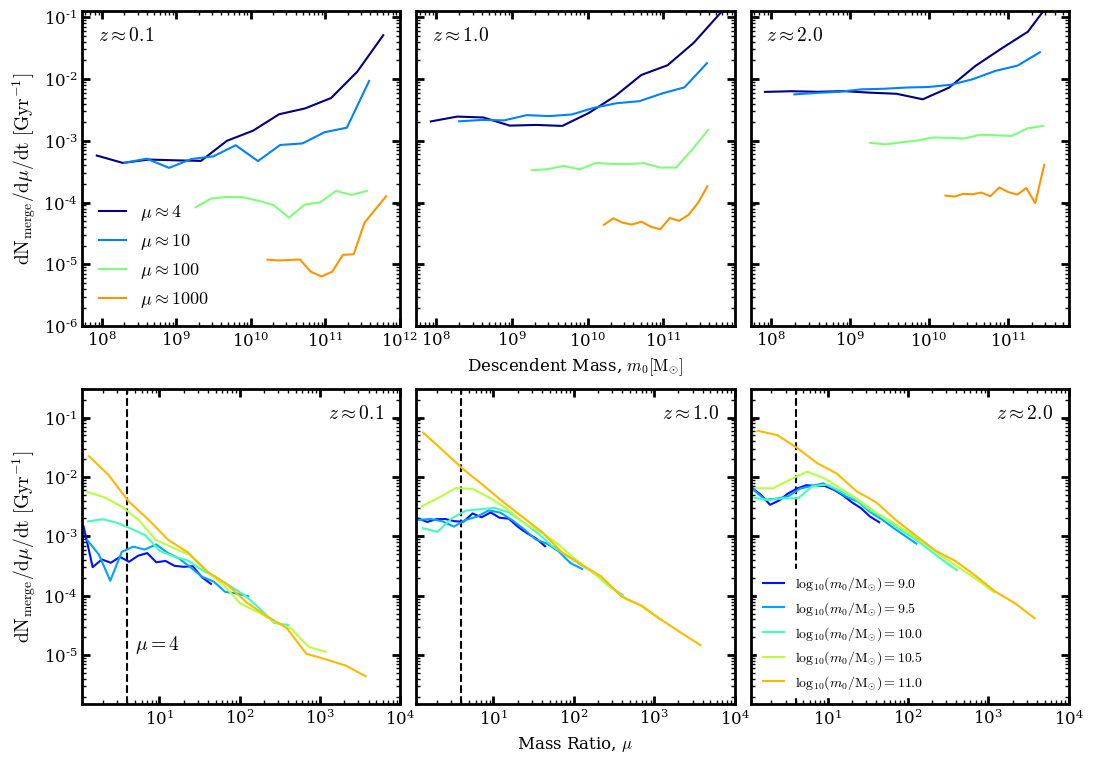

In [4]:
# Plot merger mass ratios
mass_range=[7,11]
MR_list=[4,10,100,1000]    

L = 9
plt.rcParams['figure.figsize'] = (L*np.sqrt(2), L)
plt.rcParams["font.family"] = 'serif'
text = 12
plt.rcParams.update({
    'axes.labelsize': text,
    'xtick.labelsize': text,
    'ytick.labelsize': text,
    'axes.titlesize': text,
    'legend.handlelength': 1.5,
    'mathtext.fontset': 'cm'
})
fig, ax = plt.subplots(2, 3,sharey='row')
fig.subplots_adjust(wspace=0.05)
tot = 9
for axi in ax.reshape(-1):
    axi.tick_params(axis='both', direction='in', which = 'both', bottom=True, top=True, left=True, right=True)
    axi.set_yscale('log')
    axi.set_xscale('log')
ax[1,0].set_xlim([1.1,1e4])
ax[1,1].set_xlim([1.1,1e4])
ax[1,2].set_xlim([1.1,1e4])

ax[0,0].set_ylim([1e-6,.125])


ax[0,0].set_ylabel('$\mathrm{dN_{merge}}/\mathrm{d}\mu/\mathrm{dt}\,\,[\mathrm{Gyr}^{-1}]$',size=14)
ax[1,0].set_ylabel('$\mathrm{dN_{merge}}/\mathrm{d}\mu/\mathrm{dt}\,\,[\mathrm{Gyr}^{-1}]$',size=14)

ax[0,1].set_xlabel('Descendent Mass, $m_{0}[\mathrm{M}_{\odot}]$')
ax[1,1].set_xlabel('Mass Ratio, $\mu$')

target_zs = [0.1,1,2]
mass_bins = [(np.log10(5e8),np.log10(1.5e9)),
             (np.log10(1.5e9),np.log10(5e9)),
             (np.log10(5e9),np.log10(1.5e10)),
             (np.log10(1.5e10),np.log10(5e10)),
             (np.log10(5e10),np.log10(1.5e11))]

dex = 0.15
MR_list=[(10**(np.log10(4)-dex), 10**(np.log10(4)+dex)),
         (10**(np.log10(10)-dex), 10**(np.log10(10)+dex)),
         (10**(np.log10(100)-dex), 10**(np.log10(100)+dex)),
         (10**(np.log10(1000)-dex), 10**(np.log10(1000)+dex))] 

mrs = [4,10,100,1000]
for i, redshift in enumerate(target_zs):
    galaxies = P200.galaxy.list(redshift=redshift)
    scalefactor_bin, redshift_bin, time_bin = gb.target_redshift_bin(redshift,P200.cosmology)
    redshift_label = '{:.1f}'.format(redshift)
    full_label = '$z\\approx ' + redshift_label + '$'
    ax[0,i].annotate(full_label, xy=(0.05, 1-0.05), xycoords='axes fraction', size=14, ha='left', va='top')
    ax[1,i].annotate(full_label, xy=(1-0.05, 1-0.05), xycoords='axes fraction', size=14, ha='right', va='top')

    for j, MR in enumerate(MR_list):
        N_mergers, edges = P200.galaxy.mergers.hist(axis='Desc_mstar',min_time=time_bin[0],max_time=time_bin[1],min_desc_mstar=np.log10(MR[1]*(10**P200.OutputMassThreshold)), min_MR=MR[0], max_MR=MR[1],bins=12)
        N_gals, edges = np.histogram(galaxies['Stellar_mass'],bins=edges)
        mass_centers = (edges[:-1] + edges[1:])/2
        dm = np.abs(np.diff(10**edges))
        dm = N_gals
        du = MR[1]-MR[0]
        
        clean = N_mergers>0
        ax[0,i].plot(10**mass_centers[clean],N_mergers[clean]/N_gals[clean]/du/np.diff(time_bin),color = plt.cm.jet((j)/float(4)),label = '$\mu\\approx' + '{:d}'.format(int(mrs[j]))+'$')
    
    for j, mass in enumerate(mass_bins):

        N_gals, edges = np.histogram(galaxies['Stellar_mass'],bins=mass)
        N_mergers, edges = P200.galaxy.mergers.hist(axis='MR',min_time=time_bin[0],max_time=time_bin[1],min_desc_mstar=mass[0],max_desc_mstar=mass[1], max_MR = (10**mass[0])/(10**P200.OutputMassThreshold),log=True,bins=15)

        ratio_centers = (edges[:-1] + edges[1:])/2
        dt = np.diff(time_bin)
        dz = np.abs(np.diff(redshift_bin))
        du = np.abs(np.diff(10**edges))
        dm = np.abs(10**mass[1] - 10**mass[0])
        lab = '$\log_{10}(m_{0}/\mathrm{M}_{\odot})=' + '{:.1f}'.format(np.log10(np.mean(10**np.array(mass)))) +'$' 
        if i == 2:
            ax[1,i].plot(10**ratio_centers,N_mergers/dt/du/N_gals, color = plt.cm.jet((j+1)/float(7)),label = lab)
        else:
            ax[1,i].plot(10**ratio_centers,N_mergers/dt/du/N_gals, color = plt.cm.jet((j+1)/float(7)))
        
ax[1,0].vlines(4, ymin=1e-6, ymax= 1,linestyle='--')
ax[1,1].vlines(4, ymin=1e-6, ymax= 1,linestyle='--')
ax[1,2].vlines(4, ymin=1e-6, ymax= 1,linestyle='--')
ax[1,0].set_ylim([1.5e-6,9e-2])
ax[1,0].set_ylim([1.5e-6,3e-1])
ax[1,2].legend(loc='lower left', frameon=True, facecolor='white', edgecolor='white', framealpha=1, prop={'size':10})
ax[0,0].legend(loc='lower left',frameon=False, prop={'size':13})
txt = ax[1,0].text(5,1e-5, '$\mu = '+'{:d}'.format(4)+'$', horizontalalignment='left', verticalalignment='bottom',fontsize=14)
plt.show()

Making bin evenly spaced in time
Making bin evenly spaced in time
Making bin evenly spaced in time


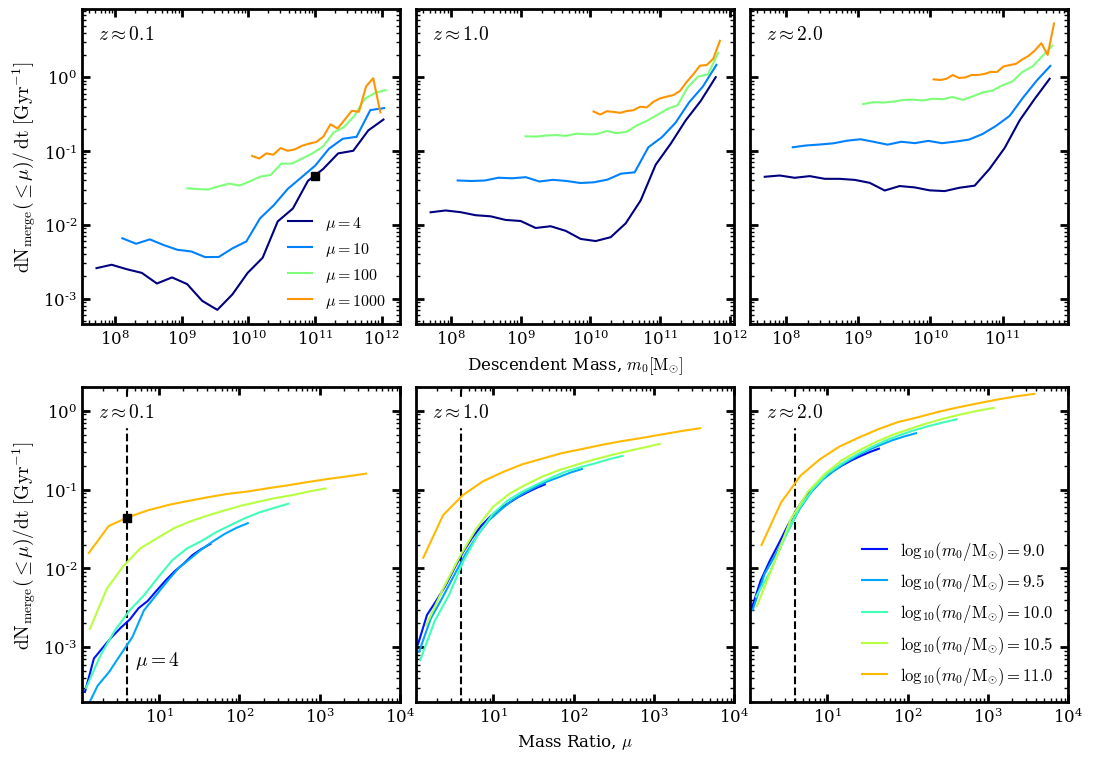

In [10]:
# Plot cumulative merger mass ratios
mass_range=[7,11]
MR_list=[4,10,100,1000]    
shrink = 1
L = 9
plt.rcParams['figure.figsize'] = (L*np.sqrt(2), shrink*L)
plt.rcParams["font.family"] = 'serif'
text = 12
plt.rcParams.update({
    'axes.labelsize': text,
    'xtick.labelsize': text,
    'ytick.labelsize': text,
    'axes.titlesize': text,
    'legend.handlelength': 1.5,
    'mathtext.fontset': 'cm'
})
fig, ax = plt.subplots(2, 3,sharey='row')
fig.subplots_adjust(wspace=0.05)
tot = 9
for axi in ax.reshape(-1):
    axi.tick_params(axis='both', direction='in', which = 'both', bottom=True, top=True, left=True, right=True)
    axi.set_yscale('log')
    axi.set_xscale('log')
ax[1,0].set_xlim([1.1,1e4])
ax[1,1].set_xlim([1.1,1e4])
ax[1,2].set_xlim([1.1,1e4])


ax[0,0].set_ylabel('$\mathrm{dN_{merge}}(\leq \mu)/\,\mathrm{dt}\,\,[\mathrm{Gyr}^{-1}]$',size=14)
ax[1,0].set_ylabel('$\mathrm{dN_{merge}}(\leq \mu)/\mathrm{dt}\,\,[\mathrm{Gyr}^{-1}]$',size=14)

ax[0,1].set_xlabel('Descendent Mass, $m_{0}[\mathrm{M}_{\odot}]$')
ax[1,1].set_xlabel('Mass Ratio, $\mu$')

target_zs = [0.1,1,2]
mass_bins = [(np.log10(5e8),np.log10(1.5e9)),
             (np.log10(1.5e9),np.log10(5e9)),
             (np.log10(5e9),np.log10(1.5e10)),
             (np.log10(1.5e10),np.log10(5e10)),
             (np.log10(5e10),np.log10(1.5e11))] 
for i, redshift in enumerate(target_zs):
    galaxies = P200.galaxy.list(redshift=redshift)
    scalefactor_bin, redshift_bin, time_bin = gb.target_redshift_bin(redshift,P200.cosmology)
    redshift_label = '{:.1f}'.format(redshift)
    full_label = '$z\\approx ' + redshift_label + '$'
    bbox_props = dict(boxstyle="square,pad=0.3", fc="white", ec="white")
    ax[0,i].annotate(full_label, xy=(0.05, 1-0.05), xycoords='axes fraction', size=14, ha='left', va='top')
    ax[1,i].annotate(full_label, xy=(0.05, 1-0.05), xycoords='axes fraction', size=14, ha='left', va='top',bbox=bbox_props)

    for j, MR in enumerate(MR_list):
        N_mergers, edges = P200.galaxy.mergers.hist(axis='Desc_mstar',min_time=time_bin[0],max_time=time_bin[1],min_desc_mstar=np.log10(MR*(10**P200.OutputMassThreshold)), max_MR=MR,bins=20)
        N_gals, edges = np.histogram(galaxies['Stellar_mass'],bins=edges)
        mass_centers = (edges[:-1] + edges[1:])/2
        dm = np.abs(np.diff(10**edges))
        dm = N_gals
        ax[0,i].plot(10**mass_centers,N_mergers/N_gals/np.diff(time_bin),color = plt.cm.jet((j)/float(4)),label = '$\mu' + '={:d}'.format(int(MR))+'$')
        if i == 0 : 
            if j == 0:
                fx = interp1d(10**mass_centers, N_mergers/N_gals/np.diff(time_bin))
                ax[0,0].plot(10**11,fx(10**11), 'ks')
    
    for j, mass in enumerate(mass_bins):
        N_gals, edges = np.histogram(galaxies['Stellar_mass'],bins=mass)

        N_mergers, edges = P200.galaxy.mergers.hist(axis='MR',min_time=time_bin[0],max_time=time_bin[1],min_desc_mstar=mass[0],max_desc_mstar=mass[1], max_MR = (10**mass[0])/(10**P200.OutputMassThreshold),log=True,bins=15)

        ratio_centers = (edges[:-1] + edges[1:])/2
        dt = np.diff(time_bin)
        du = np.abs(np.diff(10**edges))
        dm = np.abs(10**mass[1] - 10**mass[0])
        N_mergers = N_mergers.cumsum()
        lab = '$\log_{10}(m_{0}/\mathrm{M}_{\odot})=' + '{:.1f}'.format(np.log10(np.mean(10**np.array(mass)))) +'$' 
        ax[1,i].plot(10**ratio_centers,N_mergers/dt/N_gals, color = plt.cm.jet((j+1)/float(7)),label = lab)
        if i == 0 : 
            if j == 4:
                fx = interp1d(10**ratio_centers, N_mergers/dt/N_gals)
                ax[1,0].plot(4,fx(4), 'ks')

ax[1,0].vlines(4, ymin=1e-6, ymax= 2,linestyle='--')
ax[1,1].vlines(4, ymin=1e-6, ymax= 2,linestyle='--')
ax[1,2].vlines(4, ymin=1e-6, ymax= 2,linestyle='--')    
ax[1,0].set_ylim([2e-4,2])
ax[1,2].legend(loc='lower right',frameon=False, prop={'size':12})
ax[0,0].legend(loc='lower right',frameon=False, prop={'size':11.5})
txt = ax[1,0].text(5,5e-4, '$\mu = '+'{:d}'.format(4)+'$', horizontalalignment='left', verticalalignment='bottom',fontsize=14)
plt.show()

## Section 3.1.3: Active vs. Passive galaxies

Making bins evenly spaced in time


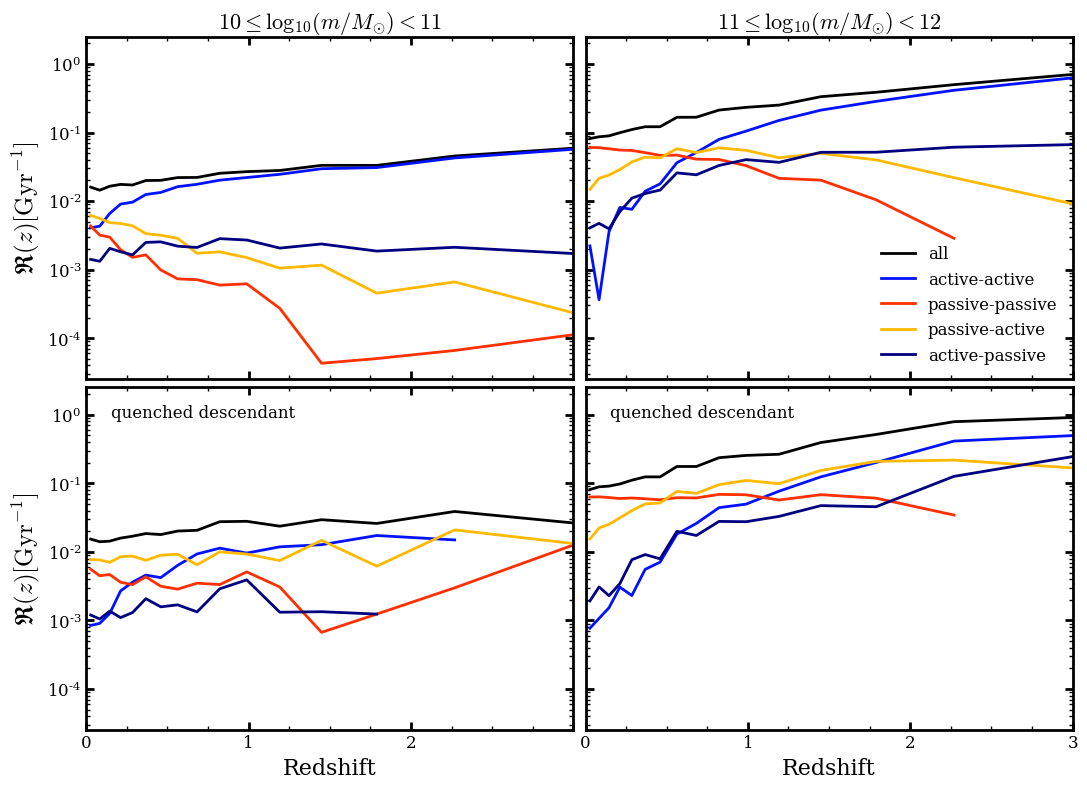

In [6]:
# active vs passive
shrink=0.75
L = 9
plt.rcParams['figure.figsize'] = (L*np.sqrt(2), L)
plt.rcParams["font.family"] = 'serif'
text = 12
plt.rcParams.update({
    'axes.labelsize': text,
    'xtick.labelsize': text,
    'ytick.labelsize': text,
    'axes.titlesize': text,
    'legend.handlelength': 2,
    'mathtext.fontset': 'cm'
})

fig, ax = plt.subplots(2, 2,sharex='col',sharey=True)
fig.subplots_adjust(wspace=0.025, hspace=0.025)
for axi in ax.reshape(-1):
    axi.tick_params(axis='both', direction='in', which = 'both', bottom=True, top=True, left=True, right=True)
    axi.xaxis.set_minor_locator(ticker.FixedLocator(np.arange(0.25, 4.75+1, 0.25)))
    axi.xaxis.set_major_locator(ticker.FixedLocator(np.arange(0, 6+1, 1)))
    axi.set_yscale('log')
    
ax[1,0].set_xlabel('Redshift',size=16)
ax[1,1].set_xlabel('Redshift',size=16)

ax[0,0].set_title('$10 \leq \log_{10}(m/M_{\odot})<11$', size=16)
ax[0,1].set_title('$11 \leq \log_{10}(m/M_{\odot})<12$', size=16)

ax[0,0].set_ylabel('$\mathfrak{R}(z)[\mathrm{Gyr}^{-1}]$',size=18)
ax[1,0].set_ylabel('$\mathfrak{R}(z)[\mathrm{Gyr}^{-1}]$',size=18)

ax[0,0].set_xlim([0,3])
ax[0,1].set_xlim([0,3])
ax[0,0].set_xticklabels(np.arange(0,3))
ax[0,1].set_xticklabels(np.arange(0,4))

scale, redshift, time = gb.make_time_bins(cosmology=P200.cosmology, db = 0.75, db_type='time')
z = (redshift[1:] + redshift[:-1])/2
dt = np.diff(time)
norm_vol = 1/(P200.BoxSize)**3
m_array = np.array([10,11,12])
mr_array = np.array([1,3,10,100])
color_array = (['any','any'],
               ['blue','blue'],
               ['red','red'],
               ['red','blue'],
               ['blue','red'])

lc_array = ['k',plt.cm.jet((1)/float(7)),plt.cm.jet((6)/float(7)), plt.cm.jet((5)/float(7)), plt.cm.jet((0)/float(7))]
lab_array = ['all', 'active-active', 'passive-passive', 'passive-active', 'active-passive']
min_MR = 1
max_MR = 4

for i in range(len(m_array)-1):
    min_mass = m_array[i]
    max_mass = m_array[i+1]
    norm_gal  = 1/P200.galaxy.count(target_scales=(scale[1:] + scale[:-1])/2, min_mass=min_mass, max_mass=max_mass)
    for j, color in enumerate(color_array):
        main_color = color[0]
        minor_color = color[1]
        N_merge, bin_edges = P200.galaxy.mergers.hist(axis='tdf', bins = time, min_desc_mstar=min_mass, max_desc_mstar=max_mass, min_MR=min_MR, max_MR=max_MR, main_color=main_color, minor_color=minor_color)
        clean = N_merge > 0
        ax[0,i].plot(z[clean],norm_gal[clean]*N_merge[clean]/dt[clean], color = lc_array[j], label=lab_array[j], lw=2)

lc_array = ['k',plt.cm.jet((1)/float(7)),plt.cm.jet((6)/float(7)), plt.cm.jet((5)/float(7)), plt.cm.jet((0)/float(7))]
lab_array = ['all', 'active-active', 'passive-passive', 'passive-active', 'active-passive']
min_MR = 1
max_MR = 4

for i in range(len(m_array)-1):
    min_mass = m_array[i]
    max_mass = m_array[i+1]
    norm_gal  = 1/P200.galaxy.count(target_scales=(scale[1:] + scale[:-1])/2, min_mass=min_mass, max_mass=max_mass, color='red')
    for j, color in enumerate(color_array):
        main_color = color[0]
        minor_color = color[1]
        N_merge, bin_edges = P200.galaxy.mergers.hist(axis='tdf', bins = time, min_desc_mstar=min_mass, max_desc_mstar=max_mass, min_MR=min_MR, max_MR=max_MR,desc_color='red',main_color=main_color, minor_color=minor_color)
        clean = N_merge > 0
        ax[1,i].plot(z[clean],norm_gal[clean]*N_merge[clean]/dt[clean], color = lc_array[j], label=lab_array[j], lw=2)

ax[1,0].annotate('quenched descendant', xy=(0.05, 1-0.05), xycoords='axes fraction', size=12, ha='left', va='top')
ax[1,1].annotate('quenched descendant', xy=(0.05, 1-0.05), xycoords='axes fraction', size=12, ha='left', va='top')
ax[0,1].legend(frameon=False, fontsize=12)
plt.show()

# Section 4: OBSERVED MERGER RATES

Pair counts were computed using a modified version of halotools. As such, this makes the pair counter less than portable. as a stand in I've included pair counts for a range of mass cuts and projected separations in this repository. Should you wish to compute pairs directly you will need to modify halotools. I cannot gurantee that these edits will work in all versions of halotools.

halotools version: 0.7.dev5002

In my version I edited weighting function 11 to perform as:
        
```cython
cdef cnp.float64_t ratio_weights(cnp.float64_t* w1, cnp.float64_t* w2):
    if (w1[0]/w2[0] >= 1) and (w1[0]/w2[0] < w1[1]):
        return w2[1]
    else:
        return 0.0
 ```
 pair counts were performed using `mock_observables.marked_npairs_xy_z`

## Section 4.1: Close galaxy pairs

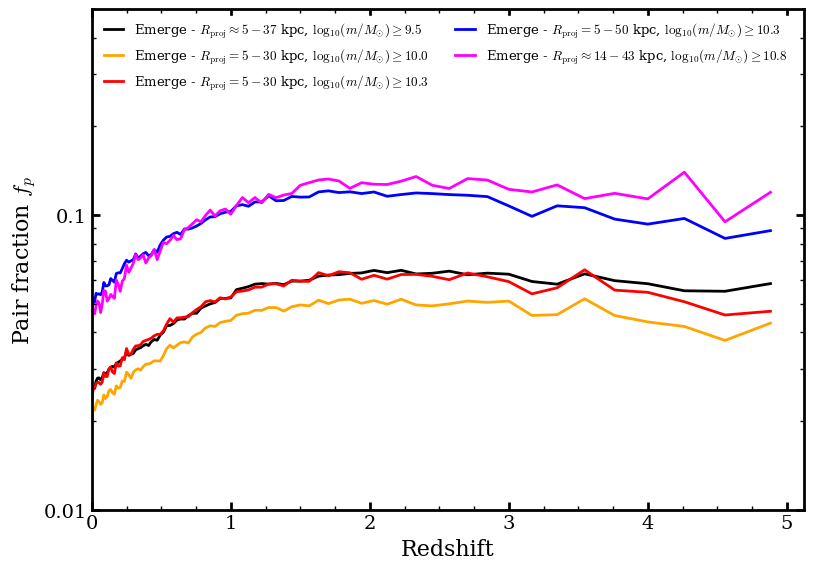

In [7]:
# Pair Franction
# I picked terrible column names for the hdf5 file. so it will probably throw a natural naming warning. 
plt.rcParams["font.family"] = 'serif'
plt.rcParams['mathtext.fontset'] = 'cm'
L = 6.5
asp = np.sqrt(2)

plt.rcParams['figure.figsize'] = (L*asp, L)

fig, ax = plt.subplots(1,1)

ax.set_xlim(0,5.125)
ax.set_ylim(0.01,1.5)
ax.set_ylabel('Pair fraction $f_{p}$', size=16)
ax.set_xlabel('Redshift', size=16)
ax.tick_params(axis='both', direction='in', which = 'both', bottom=True, top=True, left=True, right=True, labelsize=14)
ax.xaxis.set_minor_locator(ticker.FixedLocator(np.arange(0.25, 4.5+75, 0.25)))

# Emerge
kn=1
#min_mstar = 9.5
pairs = pd.read_hdf('./pair_counts.h5', key='P1')
ax.plot(pairs['redshift'], (pairs['rp:36']-pairs['rp:4'])/pairs['N_gal'],color='black', ls='-', lw=2, zorder=0)

#min_mstar = 10
pairs = pd.read_hdf('./pair_counts.h5', key='P3')
ax.plot(pairs['redshift'], (pairs['rp:30']-pairs['rp:5'])/pairs['N_gal'],color='orange', ls='-', lw=2, zorder=0)

#min_mstar = 10.3
pairs = pd.read_hdf('./pair_counts.h5', key='P4')
ax.plot(pairs['redshift'], (pairs['rp:30']-pairs['rp:5'])/pairs['N_gal'],color='red', ls='-',lw=2, zorder=0)
ax.plot(pairs['redshift'], (pairs['rp:50']-pairs['rp:5'])/pairs['N_gal'],color='blue', lw=2, zorder=0)


#min_mstar = 10.8
max_mass = np.inf
pairs = pd.read_hdf('./pair_counts.h5', key='P5')
ax.plot(pairs['redshift'], (pairs['rp:43']-pairs['rp:14'])/pairs['N_gal'],color='magenta', ls='-', lw=2, zorder=0)


ax.set_yscale('log')

handles, labels = ax.get_legend_handles_labels()
handles = [h[0] if isinstance(h, container.ErrorbarContainer) else h for h in handles]

emergeA = Line2D([0], [0], color='black', lw = 2, ls='-', label = 'Emerge - $R_{\mathrm{proj}} \\approx 5-37$ kpc, '+'$\log_{10}(m/M_{\odot}) \geq 9.5$')
emergeD = Line2D([0], [0], color='orange', lw = 2, ls='-', label = 'Emerge - $R_{\mathrm{proj}} = 5-30$ kpc, '+'$\log_{10}(m/M_{\odot}) \geq 10.0$')
emergeB = Line2D([0], [0], color='red', lw = 2, ls='-', label = 'Emerge - $R_{\mathrm{proj}} = 5-30$ kpc, '+'$\log_{10}(m/M_{\odot}) \geq 10.3$')
emergeC = Line2D([0], [0], color='blue', lw = 2, ls='-', label = 'Emerge - $R_{\mathrm{proj}} = 5-50$ kpc, '+'$\log_{10}(m/M_{\odot}) \geq 10.3$')
emergeF = Line2D([0], [0], color='magenta', lw = 2, ls='-', label = 'Emerge - $R_{\mathrm{proj}} \\approx 14-43$ kpc, '+'$\log_{10}(m/M_{\odot}) \geq 10.8$')

ax.legend(handles = [emergeA, emergeD, emergeB, emergeC, emergeF], ncol = 2, handlelength=1.5, frameon=True, fontsize=9.5, loc='upper left', facecolor='white', edgecolor='white', framealpha=1)
ax.set_ylim(0.01, 0.5)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
plt.show()

## Section 4.2: The merger rate from close pairs

Making bins evenly spaced in time


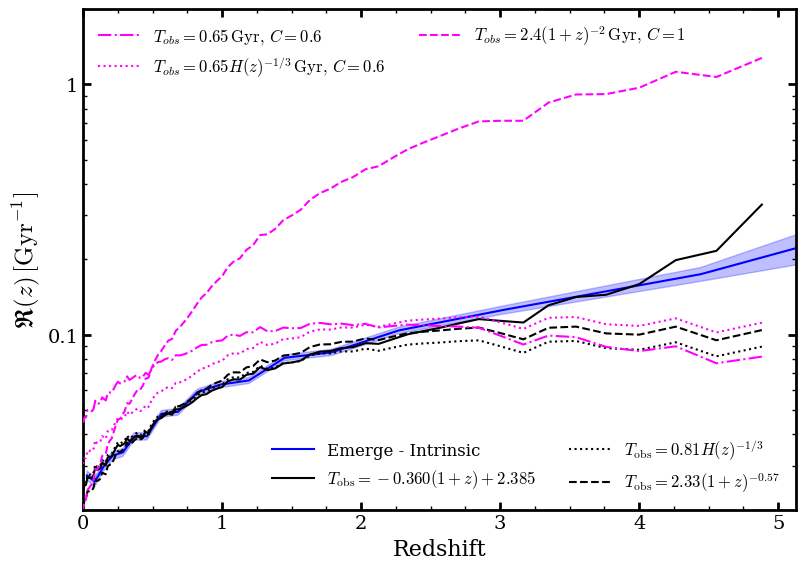

In [8]:
#
def line(x,m,b):
    return m*x + b

def powerlaw(x,alpha,m):
    return alpha * (x)**(m)

min_mass = 10.3
max_mass = np.inf
scale, redshift, time = gb.make_time_bins(cosmology=P200.cosmology, db = 0.75, db_type='time')
pairs = pd.read_hdf('./pair_counts.h5', key='P4')
N_merge, bin_edges = P200.galaxy.mergers.hist(axis='tdf', bins = time, min_main_mstar=min_mass, max_main_mstar=max_mass, min_MR=1, max_MR=4)
z = (redshift[1:] + redshift[:-1])/2
dt = np.diff(time)
norm_gal  = 1/P200.galaxy.count(target_scales=(scale[1:] + scale[:-1])/2, min_mass=min_mass, max_mass=max_mass)

green = 'green'
red = plt.cm.jet((5+1)/float(7))
plt.rcParams.update({
    'font.family': 'serif',
    'legend.handlelength': 2.5,
    'mathtext.fontset': 'cm'})

L = 6.5
asp = np.sqrt(2)
plt.rcParams['figure.figsize'] = (L*asp, L)
fig, ax = plt.subplots(1,1)
ax.set_xlim(0,5.125)
ax.set_ylim(0.01,1.6)
ax.set_ylabel('$\mathfrak{R}(z) \, [\mathrm{Gyr}^{-1}]$', size=18)
ax.set_xlabel('Redshift',size=16)
ax.tick_params(axis='both', direction='in', which = 'both', bottom=True, top=True, left=True, right=True, labelsize=14)
ax.xaxis.set_minor_locator(ticker.FixedLocator(np.arange(0.25, 4.5+75, 0.25)))
ax.set_yscale('log')
ax.set_ylim([2e-2, 2])

# INTRINSIC
z = (redshift[1:] + redshift[:-1])/2
ax.plot(z,norm_gal*N_merge/dt,'b-', label='Emerge - Intrinsic')

y = norm_gal*N_merge/dt
yu = norm_gal*(N_merge+N_merge/np.sqrt(N_merge))/dt
yd = norm_gal*(N_merge-N_merge/np.sqrt(N_merge))/dt
ax.fill_between(z,yu,yd,alpha=0.25, color='b')

fp = (pairs['rp:50']-pairs['rp:5'])/pairs['N_gal']

# BEST FIT
Tobs = line(pairs['redshift']+1,-0.360,2.385)
ax.plot(pairs['redshift'], fp/Tobs, '-', color='black', label='$T_{\mathrm{obs}} = -0.360(1+z)+2.385$',zorder=11)

Tobs = 0.81*((P200.cosmology.H(pairs['redshift']).value*apunits.km.to(apunits.Mpc, 1)/apunits.s.to(apunits.Gyr, 1))**(-1/3))
ax.plot(pairs['redshift'], fp/Tobs, ':', color='black', label='$T_{\mathrm{obs}} = 0.81H(z)^{-1/3}$',zorder=11)

Tobs = powerlaw(pairs['redshift']+1,2.33,-0.57)
ax.plot(pairs['redshift'], fp/Tobs, '--', color='black', label='$T_{\mathrm{obs}} = 2.33(1+z)^{-0.57}$',zorder=11)

# PUBLISHED
color='magenta'
C=0.6
Tobs = 0.65
ax.plot(pairs['redshift'], C*fp/Tobs, '-.', color=color,zorder=11)
P1 = Line2D([0], [0], color=color, ls='-.', label='$T_{obs}=0.65 \,\mathrm{Gyr}, \, C=0.6$')

C=0.6
Tobs = 0.65*((P200.cosmology.H(pairs['redshift']).value*apunits.km.to(apunits.Mpc, 1)/apunits.s.to(apunits.Gyr, 1))**(-1/3))
ax.plot(pairs['redshift'], fp/Tobs, ':', color=color,zorder=11)
P2 = Line2D([0], [0], color=color, ls=':', label='$T_{obs}=0.65H(z)^{-1/3} \,\mathrm{Gyr}, \, C=0.6$')

Tobs = powerlaw(pairs['redshift']+1,2.4,-2)
ax.plot(pairs['redshift'], fp/Tobs, '--', color=color,zorder=11)
P3 = Line2D([0], [0], color=color, ls='--', label='$T_{obs}=2.4(1+z)^{-2} \,\mathrm{Gyr}, \, C=1$')

leg = ax.legend(handles=[P1, P2, P3], loc='upper left',frameon=False, fontsize=12, ncol=2)
ax.add_artist(leg)
ax.legend(ncol=2, fontsize=12, loc='lower right',frameon=True, facecolor='white', edgecolor='white', framealpha=1)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
plt.show()

# Section 5: WHICH GALAXIES GROW THROUGH MERGERS?

## Section 5.1: Stellar mass fraction accreted through different mergertypes

In [11]:
# exsitu
# this could take some time. go get some coffee or something.
def exsitu_fraction_wrapper(igal):
    return P200.galaxy.exsitu_mass(igal, frac=frac, min_MR=min_MR, max_MR=max_MR, root=True)

def parallel_exsitu_fraction(num_procs=1, **kwargs):
    roots = P200.galaxy.list(**kwargs).index.values
    with Pool(processes=num_procs) as pool:
        result = np.array(list(pool.map(exsitu_fraction_wrapper, roots)))
    return result
frac='exsitu'
min_mstar=9
num_procs=8

frac=None
min_MR=1
max_MR=np.inf
ex0 = parallel_exsitu_fraction(min_mstar=min_mstar,num_procs=num_procs)

min_MR=1
max_MR=2
ex1 = parallel_exsitu_fraction(min_mstar=min_mstar,num_procs=num_procs)

min_MR=1
max_MR=3
ex2 = parallel_exsitu_fraction(min_mstar=min_mstar,num_procs=num_procs)

min_MR=1
max_MR=4
ex3 = parallel_exsitu_fraction(min_mstar=min_mstar,num_procs=num_procs)

min_MR=4
max_MR=10
ex4 = parallel_exsitu_fraction(min_mstar=min_mstar,num_procs=num_procs)

min_MR=4
max_MR=np.inf
ex5 = parallel_exsitu_fraction(min_mstar=min_mstar,num_procs=num_procs)

min_MR=10
max_MR=np.inf
ex6 = parallel_exsitu_fraction(min_mstar=min_mstar,num_procs=num_procs)

min_MR=2
max_MR=np.inf
ex7 = parallel_exsitu_fraction(min_mstar=min_mstar,num_procs=num_procs)


gals = P200.galaxy.list(min_mstar=9)

extotal = np.array([10.**gals['Stellar_mass'].values, ex0[:,0]])
exmajor = np.array([10.**gals['Stellar_mass'].values, ex3[:,0]])
exminor = np.array([10.**gals['Stellar_mass'].values, ex4[:,0]])
exmini = np.array([10.**gals['Stellar_mass'].values, ex6[:,0]])

exmajor1 = np.array([10.**gals['Stellar_mass'].values, ex1[:,0]])
exmajor2 = np.array([10.**gals['Stellar_mass'].values, ex2[:,0]])

exminor1 = np.array([10.**gals['Stellar_mass'].values, ex5[:,0]])
exminor2 = np.array([10.**gals['Stellar_mass'].values, ex7[:,0]])

In [12]:
# exsitu binning
bins = np.arange(9.0,12.05,0.15)
mbintot,_,_  = binned_statistic(np.log10(extotal[0]),np.log10(extotal[0]),statistic='mean',bins=bins)
mextot,_,_   = binned_statistic(np.log10(extotal[0]),extotal[1],statistic='sum',bins=bins)
mstartot,_,_ = binned_statistic(np.log10(extotal[0]),extotal[0],statistic='sum',bins=bins)
fextot       = mextot/mstartot

mbinmaj,_,_  = binned_statistic(np.log10(exmajor[0]),np.log10(exmajor[0]),statistic='mean',bins=bins)
mexmaj,_,_   = binned_statistic(np.log10(exmajor[0]),exmajor[1],statistic='sum',bins=bins)
mstarmaj,_,_ = binned_statistic(np.log10(exmajor[0]),exmajor[0],statistic='sum',bins=bins)
fexmaj       = mexmaj/mstarmaj
fexmaj_1     = mexmaj/mextot

mbinminor,_,_  = binned_statistic(np.log10(exminor[0]),np.log10(exminor[0]),statistic='mean',bins=bins)
mexminor,_,_   = binned_statistic(np.log10(exminor[0]),exminor[1],statistic='sum',bins=bins)
mstarminor,_,_ = binned_statistic(np.log10(exminor[0]),exminor[0],statistic='sum',bins=bins)
fexminor       = mexminor/mstarminor
fexminor_1     = mexminor/mextot

mbinmini,_,_  = binned_statistic(np.log10(exmini[0]),np.log10(exmini[0]),statistic='mean',bins=bins)
mexmini,_,_   = binned_statistic(np.log10(exmini[0]),exmini[1],statistic='sum',bins=bins)
mstarmini,_,_ = binned_statistic(np.log10(exmini[0]),exmini[0],statistic='sum',bins=bins)
fexmini       = mexmini/mstarmini
fexmini_1     = mexmini/mextot


mbinmaj1,_,_  = binned_statistic(np.log10(exmajor1[0]),np.log10(exmajor1[0]),statistic='mean',bins=bins)
mexmaj1,_,_   = binned_statistic(np.log10(exmajor1[0]),exmajor1[1],statistic='sum',bins=bins)
mstarmaj1,_,_ = binned_statistic(np.log10(exmajor1[0]),exmajor1[0],statistic='sum',bins=bins)
fexmaj1       = mexmaj1/mstarmaj1
fexmaj1_1     = mexmaj1/mextot

mbinmaj2,_,_  = binned_statistic(np.log10(exmajor2[0]),np.log10(exmajor2[0]),statistic='mean',bins=bins)
mexmaj2,_,_   = binned_statistic(np.log10(exmajor2[0]),exmajor2[1],statistic='sum',bins=bins)
mstarmaj2,_,_ = binned_statistic(np.log10(exmajor2[0]),exmajor2[0],statistic='sum',bins=bins)
fexmaj2       = mexmaj2/mstarmaj2
fexmaj2_1     = mexmaj2/mextot


mbinminor1,_,_  = binned_statistic(np.log10(exminor1[0]),np.log10(exminor1[0]),statistic='mean',bins=bins)
mexminor1,_,_   = binned_statistic(np.log10(exminor1[0]),exminor1[1],statistic='sum',bins=bins)
mstarminor1,_,_ = binned_statistic(np.log10(exminor1[0]),exminor1[0],statistic='sum',bins=bins)
fexminor1       = mexminor1/mstarminor1
fexminor1_1     = mexminor1/mextot

mbinminor2,_,_  = binned_statistic(np.log10(exminor2[0]),np.log10(exminor2[0]),statistic='mean',bins=bins)
mexminor2,_,_   = binned_statistic(np.log10(exminor2[0]),exminor2[1],statistic='sum',bins=bins)
mstarminor2,_,_ = binned_statistic(np.log10(exminor2[0]),exminor2[0],statistic='sum',bins=bins)
fexminor2       = mexminor2/mstarminor2
fexminor2_1     = mexminor2/mextot

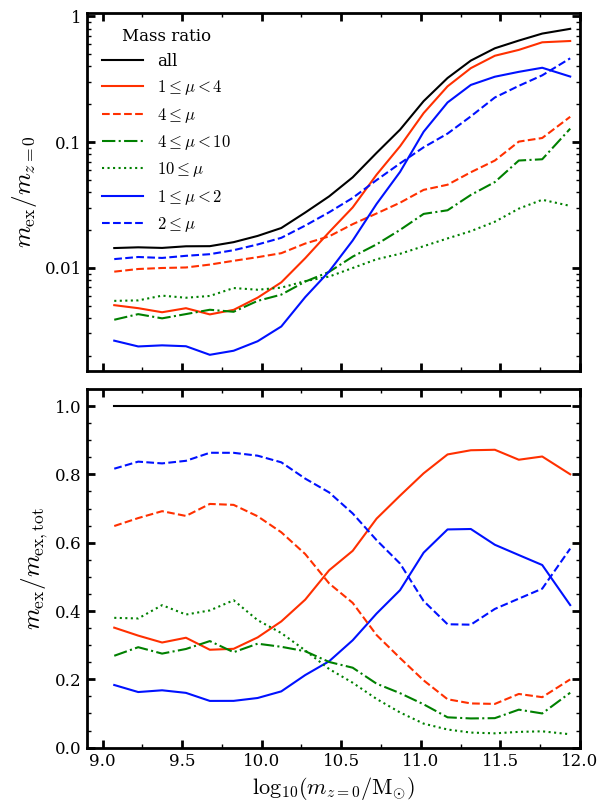

In [13]:
# exsitu plot

L = 9
shrink = 0.75

fig, ax = plt.subplots(2,1, figsize=(L*np.sqrt(2)/2, L*np.sqrt(2)*shrink), sharex='col')
fig.subplots_adjust(hspace=0.05)
ax[0].tick_params(axis='both', direction='in', which = 'both', bottom=True, top=True, left=True, right=True)

ax[1].set_ylim([0,1.05])
ax[0].set_xlim([8.8,12])
ax[1].xaxis.set_minor_locator(ticker.FixedLocator(np.arange(9,13,0.25)))
ax[1].yaxis.set_minor_locator(ticker.FixedLocator(np.arange(0,1,0.05)))
ax[1].set_ylabel('$m_{\mathrm{ex}}/m_{\mathrm{ex,tot}}$', size=18)

ax[1].tick_params(axis='both', direction='in', which = 'both', bottom=True, top=True, left=True, right=True)
ax[1].set_xlim([8.9,12])
ax[1].xaxis.set_minor_locator(ticker.FixedLocator(np.arange(9,13,0.25)))

ax[0].set_yscale('log')
ax[0].set_ylabel('$m_{\mathrm{ex}}/m_{z=0}$',size=18)
ax[1].set_xlabel('$\log_{10}(m_{z=0} /\mathrm{M}_{\odot})$',size=16)

ax[0].plot(mbintot,fextot,'k-',label='all')
ax[0].plot(mbinmaj,fexmaj,'-',color=plt.cm.jet((5+1)/float(7)), label='$1 \leq \mu < 4$')
ax[0].plot(mbinminor1,fexminor1,color=plt.cm.jet((5+1)/float(7)), ls='--',label='$4 \leq \mu$')

ax[0].plot(mbinminor,fexminor,'-.',color='g',label='$4 \leq \mu < 10$')
ax[0].plot(mbinmini,fexmini,':',color='g',label='$10 \leq \mu$')

ax[0].plot(mbinmaj1,fexmaj1,color=plt.cm.jet((0+1)/float(7)), ls='-',label='$1 \leq \mu < 2$')
ax[0].plot(mbinminor2,fexminor2,color=plt.cm.jet((0+1)/float(7)), ls='--',label='$2 \leq \mu$')

ax[1].plot(mbintot,fexmaj_1+fexminor_1+fexmini_1,'k-')
ax[1].plot(mbinmaj1,fexmaj1_1,color=plt.cm.jet((0+1)/float(7)), ls='-')


ax[1].plot(mbinmaj,fexmaj_1,'-',color=plt.cm.jet((5+1)/float(7)))
ax[1].plot(mbinminor,fexminor_1,'-.',color='g')
ax[1].plot(mbinminor1,fexminor1_1,color=plt.cm.jet((5+1)/float(7)), ls='--')
ax[1].plot(mbinminor2,fexminor2_1,color=plt.cm.jet((0+1)/float(7)), ls='--')


ax[1].plot(mbinmini,fexmini_1,':',color='g')

ax[0].legend(title='Mass ratio', title_fontsize = 12, frameon=False, prop = {'size':12})
ax[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
plt.show()

In [9]:
# mass weighted mass ratio
glist = P200.galaxy.list(min_mass=9)
def mu_wrapper(igal):
    return P200.galaxy.mass_weighted_mass_ratio(igal)
num_procs = 8
p = Pool(num_procs)
mu = np.array(p.map(mu_wrapper, glist.index.values))
glist = glist.loc[~np.isnan(mu)]
mu = mu[~np.isnan(mu)]

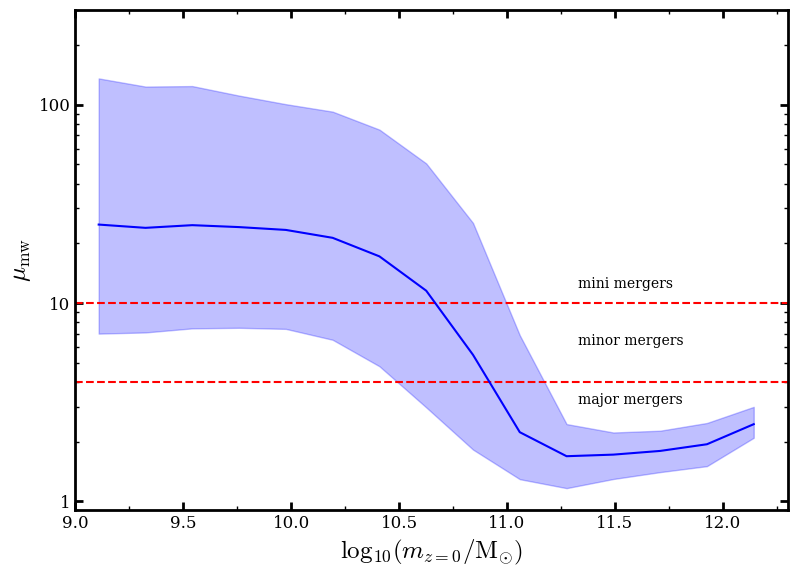

In [10]:
# mass weighted mass ratio plot

def percentile_upper(values):
    q = 84
    return np.percentile(values,q=q)
def percentile_lower(values):
    q = 16
    return np.percentile(values,q=q)

mu2, edges, binnumber = binned_statistic(glist['Stellar_mass'], mu,statistic='median',bins=15)
mu_u, edges, binnumber = binned_statistic(glist['Stellar_mass'], mu,percentile_upper,bins=15)
mu_l, edges, binnumber = binned_statistic(glist['Stellar_mass'], mu,percentile_lower,bins=15)
b = (edges[1:] + edges[:-1]) / 2

fig, ax = plt.subplots(1,1)
ax.tick_params(axis='both', direction='in', which = 'both', bottom=True, top=True, left=True, right=True)
ax.xaxis.set_minor_locator(ticker.FixedLocator(np.arange(9,13,0.25)))
ax.set_yscale('log')
ax.set_ylim([0.9,300])
ax.set_xlim([9,12.3])
ax.axhline(y=4,color='r',ls='--')
ax.axhline(y=10,color='r',ls='--')
ax.set_ylabel('$\mu_{\mathrm{mw}}$',size=18)
ax.set_xlabel('$\log_{10}(m_{z=0} /\mathrm{M}_{\odot})$',size=18)
ax.plot(b,mu2,'b-')
ax.fill_between(b,mu_u,mu_l,alpha=0.25, color='b')
plt.annotate('minor mergers', xy=(9, 4), xytext=(11.33, 7),horizontalalignment='left', verticalalignment='top')
plt.annotate('major mergers', xy=(9, 4), xytext=(11.33, 3.5),horizontalalignment='left', verticalalignment='top')
plt.annotate('mini mergers', xy=(9, 4), xytext=(11.33, 11.5),horizontalalignment='left', verticalalignment='bottom')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
plt.show()

## Section 5.2: How frequent are different kinds of mergers?

In [3]:
# merger frequencies
def Nm_wrapper(igal):
    return P200.galaxy.count_mergers(igal, min_MR=min_MR, max_MR=max_MR)

def parallel_Nm(num_procs=1, **kwargs):
    roots = P200.galaxy.list(**kwargs).index.values
    with Pool(processes=num_procs) as pool:
        result = np.array(list(pool.map(Nm_wrapper, roots)))
    return result

min_mstar=9
num_procs=8

min_MR=1
max_MR=4
navg1 = parallel_Nm(min_mstar=min_mstar, num_procs=num_procs)

min_MR=1
max_MR=2
navg4 = parallel_Nm(min_mstar=min_mstar, num_procs=num_procs)

min_MR=1
max_MR=3
navg5 = parallel_Nm(min_mstar=min_mstar, num_procs=num_procs)

min_MR=4
max_MR=np.inf
navg6 = parallel_Nm(min_mstar=min_mstar, num_procs=num_procs)


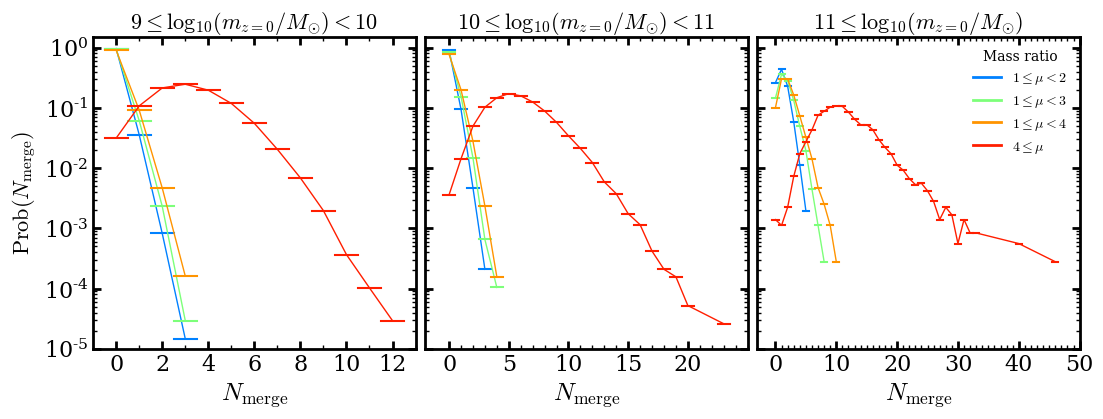

In [6]:
# Plot total lifetime main branch mergers for all galaxies various major thresholds
gals = P200.galaxy.list(min_mstar=9)
data = (navg4, navg5, navg1, navg6)
L = 9
shrink=0.9
fig, ax = plt.subplots(1, 3, figsize=(L * np.sqrt(2), shrink* L / 2), sharey='row')
fig.subplots_adjust(wspace=0.03)

ax[0].xaxis.set_minor_locator(ticker.FixedLocator(np.arange(0,25,1)))
ax[0].set_yscale('log')

ax[0].set_ylim([1e-5,1.5])
#ax[0].set_ylim([0,1])
#ax[0].set_ylabel('$\mathrm{Total\, mergers\, per\, galaxy}\,\, \\frac{N_{\mathrm{merge,mb}}}{N_{\mathrm{gal}}}$',size=16)
ax[0].set_ylabel('$\mathrm{Prob}(N_{\mathrm{merge}})$',size=16)
ax[0].set_title('$9 \leq \log_{10}(m_{z=0}/M_{\odot})<10$', size=16)
ax[1].set_title('$10 \leq \log_{10}(m_{z=0}/M_{\odot})<11$', size=16)
ax[2].set_title('$11 \leq \log_{10}(m_{z=0}/M_{\odot})$', size=16)
ax[0].set_xlim([-1,13])
ax[1].set_xlim([-2,25])
ax[2].set_xlim([-3,50])

for axi in ax.reshape(-1):
    axi.tick_params(axis='both', direction='in', which = 'both', bottom=True, top=True, left=True, right=True)
    axi.xaxis.set_minor_locator(ticker.FixedLocator(np.arange(0,51,1)))
    axi.set_xlabel('$N_{\mathrm{merge}}$',size=18)
ax[0].xaxis.set_major_locator(ticker.FixedLocator(np.arange(0,13,2)))
ax[1].xaxis.set_major_locator(ticker.FixedLocator(np.arange(0,25,5)))
ax[2].xaxis.set_major_locator(ticker.FixedLocator(np.arange(0,51,10)))
    
mass_bins = [(9,10),(10,11),(11,13)]
colors = [0,1,2,2.5]

for j, mass in enumerate(mass_bins):
    gs_mask = (gals['Stellar_mass'] >= mass[0]) & (gals['Stellar_mass'] <mass[1])
    for k in range(len(data)):
        N_tots = data[k][gs_mask]
        bin_m = np.arange(np.min(N_tots)-0.5,np.max(N_tots)+1,1)
        counts, edges = np.histogram(N_tots,bins = bin_m)
        x = (edges[1:] + edges[:-1]) / 2
        for i,N in enumerate(counts):
            x0 = x[i] - 0.5
            x1 = x[i] + 0.5
            ax[j].plot([x0,x1],np.array([N,N])/len(N_tots),color=plt.cm.jet((colors[k]+1)/float(4)))
        c_mask = counts>0
        ax[j].plot(x[c_mask],counts[c_mask]/len(N_tots),color=plt.cm.jet((colors[k]+1)/float(4)),lw=1)

major = Line2D([0], [0], color=plt.cm.jet((0+1)/float(4)), lw=2, label='$1 \leq \mu < 2$')
minor = Line2D([0], [0], color=plt.cm.jet((1+1)/float(4)), lw=2, label='$1\leq \mu < 3$')
semi = Line2D([0], [0], color=plt.cm.jet((2+1)/float(4)), lw=2, label='$1\leq \mu < 4$')
mini = Line2D([0], [0], color=plt.cm.jet((3.5)/float(4)), lw=2, label='$4 \leq \mu$')
ax[2].legend(title='Mass ratio', handles=[major, minor, semi, mini],frameon=False)
plt.show()